In [3]:
import ee, datetime
import pandas as pd
ee.Initialize()

In [10]:
import matplotlib.pyplot as plt

In [12]:
from scipy.signal import savgol_filter

In [20]:
import numpy as np

In [5]:
rf = ee.Geometry.Point([116.966795, -32.506067])

In [7]:
modis = ee.ImageCollection("MODIS/061/MYD13Q1") \
    .filterBounds(rf) \
    .filterDate('2016-01-01', '2024-12-31') \
    .select('EVI')

In [8]:
def get_evi(img):
    return img.sample(region=rf, scale=250).first().set('system:time_start', img.get('system:time_start'))

evi_samples = modis.map(get_evi).filter(ee.Filter.notNull(['EVI']))

evi_list = evi_samples.aggregate_array('EVI').getInfo()
dates = evi_samples.aggregate_array('system:time_start').getInfo()

In [9]:
date_list = [datetime.datetime.utcfromtimestamp(ts / 1000) for ts in dates]
df = pd.DataFrame({'Date': date_list, 'EVI': [val * 0.0001 for val in evi_list]})
print(df)

          Date     EVI
0   2016-01-09  0.1361
1   2016-01-25  0.1758
2   2016-02-10  0.1490
3   2016-02-26  0.1539
4   2016-03-13  0.1618
..         ...     ...
202 2024-10-23  0.3035
203 2024-11-08  0.2065
204 2024-11-24  0.1490
205 2024-12-10  0.1920
206 2024-12-26  0.1689

[207 rows x 2 columns]


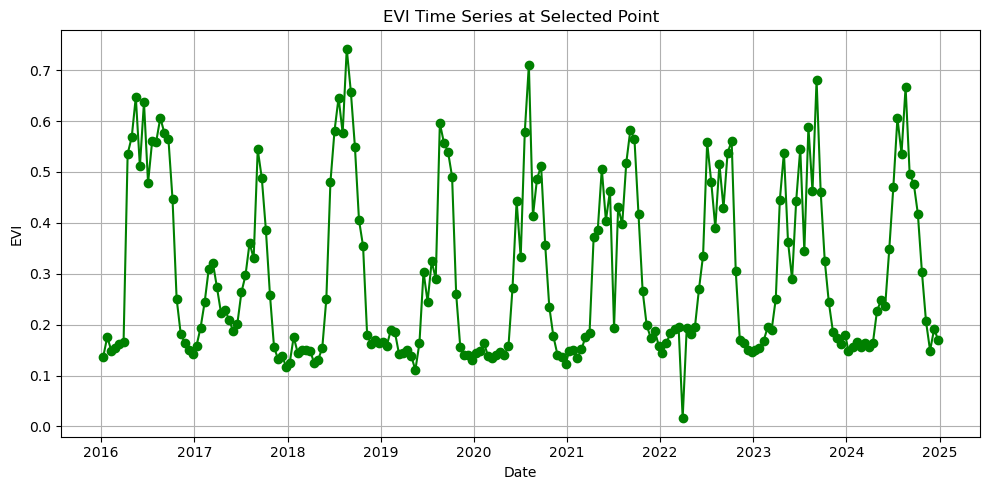

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['EVI'], marker='o', linestyle='-', color='green')
plt.title('EVI Time Series at Selected Point')
plt.xlabel('Date')
plt.ylabel('EVI')
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
window_length = 7  # Adjust based on data length (e.g., 7 for ~3-month smoothing)
polyorder = 3

df['EVI_smooth'] = savgol_filter(df['EVI'], window_length=window_length, polyorder=polyorder)

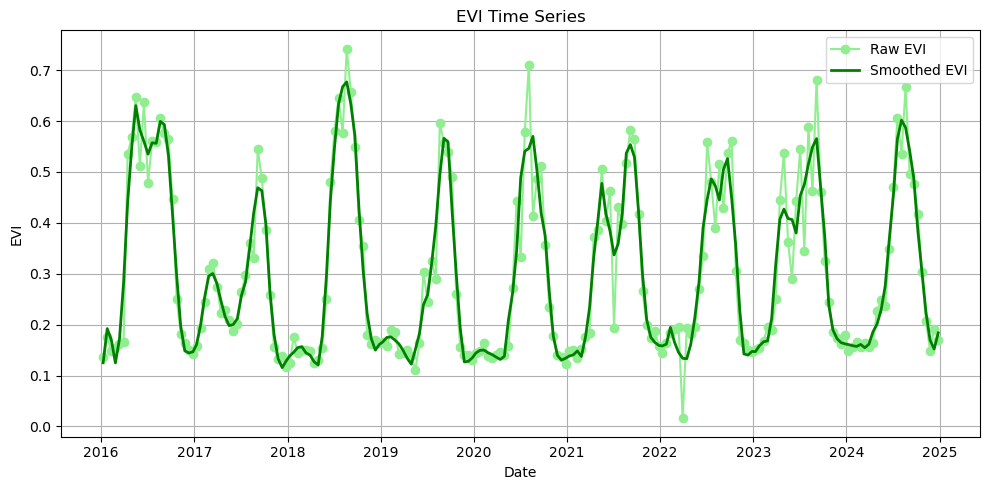

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['EVI'], label='Raw EVI', color='lightgreen', marker='o')
plt.plot(df['Date'], df['EVI_smooth'], label='Smoothed EVI', color='green', linewidth=2)
plt.title('EVI Time Series')
plt.xlabel('Date')
plt.ylabel('EVI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('evi_time_series.png', dpi=300)
plt.show()

In [21]:
# Assume df has 'Date' and 'EVI_smooth'
df['DOY'] = df['Date'].dt.dayofyear

# Group by DOY to get mean EVI over the year (for multiple years)
mean_doy = df.groupby('DOY')['EVI_smooth'].mean().reset_index()

# Calculate amplitude and threshold
evi_min = mean_doy['EVI_smooth'].min()
evi_max = mean_doy['EVI_smooth'].max()
amplitude = evi_max - evi_min
threshold = evi_min + 0.2 * amplitude

# Find SOS and EOS
above_threshold = mean_doy[mean_doy['EVI_smooth'] > threshold]
sos = above_threshold['DOY'].iloc[0]
eos = above_threshold['DOY'].iloc[-1]

print(f"Start of Growing Season (SOS): Day {sos}")
print(f"End of Growing Season (EOS): Day {eos}")

Start of Growing Season (SOS): Day 105
End of Growing Season (EOS): Day 297


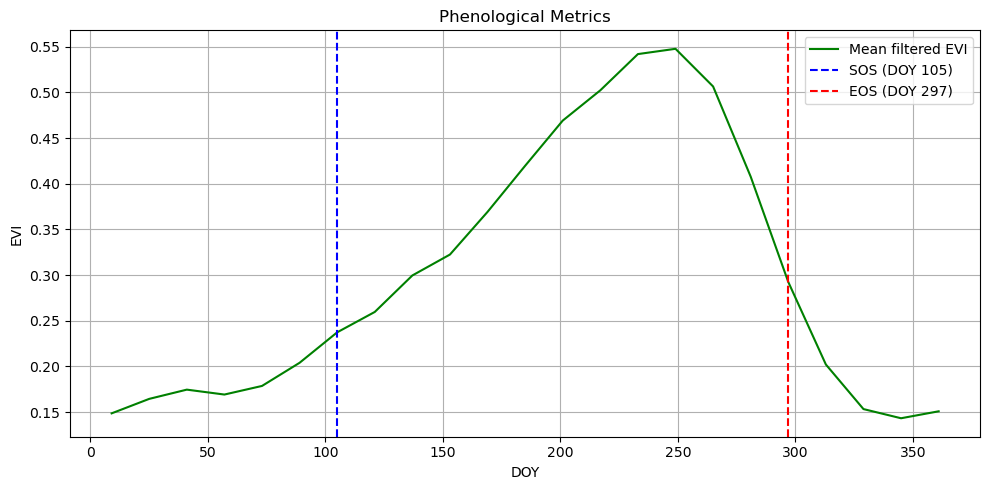

In [25]:
# Plot mean EVI curve
plt.figure(figsize=(10, 5))
plt.plot(mean_doy['DOY'], mean_doy['EVI_smooth'], label='Mean filtered EVI', color='green')

# Plot threshold line
#plt.axhline(y=threshold, color='gray', linestyle='--', label='20% Threshold')

# Plot SOS and EOS as vertical lines
plt.axvline(x=sos, color='blue', linestyle='--', label=f'SOS (DOY {sos})')
plt.axvline(x=eos, color='red', linestyle='--', label=f'EOS (DOY {eos})')

# Annotations
plt.title('Phenological Metrics')
plt.xlabel('DOY')
plt.ylabel('EVI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('phenology_metrics.png', dpi=300)
plt.show()